# GAIA DR2 - making PhoSim catalogs

In [56]:
#NB: use Python 3 - AXS Spark kernel for that 
#that's the one that has mariadb...

import pandas as pd
import numpy as np
import mysql.connector as mariadb
from astropy.time import Time
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns',100)
pd.set_option('float_format', '{:f}'.format)

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

import pyspark.sql.functions as sparkfunc
from pyspark.sql import SparkSession

spark_session = (SparkSession.builder
         .config('spark.master', "local[20]")
         .config('spark.driver.memory', '20G')
         .enableHiveSupport()
         .getOrCreate())

import axs
axs_catalog = axs.AxsCatalog(spark_session)
gaia = axs_catalog.load("gaia_dr2_1am_dup")

In [57]:
axs_catalog.list_table_names()

['sdss_zoned1am_hd',
 'gaia_zoned1am_hd',
 'gaia_dr2_1am_dup',
 'sdss_zoned1am_700lc',
 'gaia_dr2_700lc2',
 'allwise_1am_dup',
 'gaia_sdss_wise_1asec',
 'gaia_sdss_3asec',
 'ztf_1am_old',
 'ztf_exposures',
 'ztf_1am_lc',
 'ztf_1am',
 'ztf_1am_test',
 'sesar_rrlyrae',
 'ztf_fid1_sdss_stars_lt20_2asec',
 'ztf_fid2_sdss_stars_lt20_2asec',
 'ztf_fid3_sdss_stars_lt20_2asec',
 'sdss_dr9_qso_s82',
 'faraway_training_dataset',
 'faraway_labeled_training_dataset',
 'ztf_nobs100',
 'jnk_ztf_test',
 'jnk_ztf_test2',
 'ztf1000',
 'ztf10',
 'ztf_dec18',
 'asassn_variability_catalog',
 'ztf10_assasn',
 'ztf10_assasn_cesium',
 'ztf10_assasn_best',
 'ztf10_assasn_cesium_best',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'cesium_speedtest_ztfsample',
 'paula_listcvs',
 'dambis_rrlyrae_metalicity',
 'sdss_500b_28e_10800z',
 'gaia_500b_28e_10800z',
 'allwise_500b_28e_10800z',
 'ztf_500b_28e_10800z',
 'ztf_mar19_all',
 'ztf_dr1_s82_qso',
 'green19_stellar_params',
 'catalina_variables_n',
 'caltech_rosa

In [10]:
axs_catalog.table_info('gaia_dr2_1am_dup')

{'table_id': 47,
 'table_name': 'gaia_dr2_1am_dup',
 'num_buckets': 500,
 'zone_height': 0.0166666666,
 'bucket_col': 'zone',
 'ra_col': 'ra',
 'dec_col': 'dec',
 'has_lightcurves': False,
 'lc_columns': None}

In [58]:
gaia = axs_catalog.load("gaia_dr2_1am_dup")

In [55]:
np.ravel(gaia.columns)

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [7]:
%%time
r1 = gaia.region(ra1=0, ra2=0.4, dec1=-0.4, dec2=0.4).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()

r2 = gaia.region(ra1=359.6, ra2=360, dec1=-0.4, dec2=0.4).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()

CPU times: user 74.4 ms, sys: 21.9 ms, total: 96.4 ms
Wall time: 43.1 s


In [8]:
r2['ra_'] = r2['ra']-360

In [32]:
r2['ra_']

0      -0.399329
1      -0.391624
2      -0.386195
3      -0.376580
4      -0.348201
          ...   
1066   -0.082269
1067   -0.043527
1068   -0.033483
1069   -0.000157
1070   -0.000081
Name: ra_, Length: 1071, dtype: float64

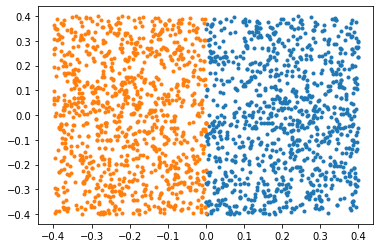

In [9]:
%matplotlib inline 
plt.plot(r1['ra'], r1['dec'], '.')
plt.plot(r2['ra_'], r2['dec'], '.')

In [15]:
r2[:4]

,ra,dec,phot_g_mean_mag,phot_variable_flag,designation,phot_g_n_obs,dup,ra_
0,359.600671,0.305844,18.926210,NOT_AVAILABLE,Gaia DR2 2642182379200351872,329,0,-0.399329
1,359.608376,0.302637,16.892691,NOT_AVAILABLE,Gaia DR2 2642182383496166912,318,0,-0.391624
2,359.613805,0.308957,15.370433,NOT_AVAILABLE,Gaia DR2 2642182383496166784,327,0,-0.386195
3,359.623420,0.313871,20.188049,NOT_AVAILABLE,Gaia DR2 2642182211697474816,218,0,-0.376580


In [10]:


r1t = Table.from_pandas(r1)
r2t = Table.from_pandas(r2)


In [11]:
results = vstack([r1t, r2t], join_type='inner') # so we loose ra_ column ... 
results['starId'] = np.arange(len(results))
results.write('GaiaDR2_0.64_deg_sq.txt', format='ascii')

In [3]:
results = Table.read('GaiaDR2_0.64_deg_sq.txt', format='ascii')

In [4]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

fig,ax = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('N=%d GAIA DR2 sources'%len(results))
ax[0].hist(results['phot_g_mean_mag'], histtype='step',lw=2, bins=20)
ax[0].set_xlabel('phot_g_mean_mag')
ax[0].set_ylabel('count')
# I plot here separately r1 and r2 because otherwise 
#inner stacking takes away the ra_  shifted column that 
# is present only in the left part of the query ... 
ax[1].scatter(r1['ra'], r1['dec'],s=r1['phot_g_mean_mag'], c='b', alpha=0.6)
ax[1].scatter(r2['ra_'], r2['dec'], s=r2['phot_g_mean_mag'],c='b',alpha=0.6)

# plot sources that are brighter than 10 - should they be excluded ? 
cutMag = 11
m = r1['phot_g_mean_mag'] < cutMag
ax[1].scatter(r1['ra'][m], r1['dec'][m],s=50, c='orange', alpha=0.6)

m = r2['phot_g_mean_mag'] < cutMag
ax[1].scatter(r2['ra_'][m], r2['dec'][m],s=50, c='orange', alpha=0.6)



ax[1].set_xlabel('ra')
ax[1].set_ylabel('dec')
plt.savefig('GAIA_DR2_ComCam_FOV.png', bbox_inches='tight', dpi=100)

<IPython.core.display.Javascript object>

NameError: name 'r1' is not defined

There are built-in limits in https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/bsc/Filter.py  . Te-Wei said "The values initially comes from the SPT-343.We could put those values into a configuration file instead of hard-coded in a latter time." , and he acknowleged that sources outside of these ranges are discarded to decrease the memory use  - apparently according to the 2016-2017 UW study, "for each CCD, we could have >1500 - 2000 stars. The number of sources in this spec will be only < 100 stars."
    
     # Magnitude boundary for each filter type
    U_LOW_MAG = 7.94
    U_HIGH_MAG = 14.80

    G_LOW_MAG = 9.74
    G_HIGH_MAG = 16.17

    R_LOW_MAG = 9.56
    R_HIGH_MAG = 15.73

    I_LOW_MAG = 9.22
    I_HIGH_MAG = 15.26

    Z_LOW_MAG = 8.83
    Z_HIGH_MAG = 14.68

    Y_LOW_MAG = 8.02
    Y_HIGH_MAG = 13.76
    
    

Since we want to see how the realistic field would look like, I'm not going to make any cuts: save in the format 

    # Id	 Ra		 Decl		 Mag
    0	 359.704865	 -0.249369	 16.000000
    1	 359.708385	 -0.249369	 16.000000
    2	 359.704865	 -0.014669	 16.000000
    3	 359.708385	 -0.014669	 16.000000
    4	 359.704865	 0.220031	 16.000000

Use exactly the same writing routine as ts_phosim `exportSkyToFile` : https://github.com/lsst-ts/ts_phosim/blob/master/python/lsst/ts/phosim/SkySim.py 
    
    

In [5]:
# Add the header (star ID, ra, decl, magnitude)

cutMag = 11 
selection = results[results['phot_g_mean_mag'] > cutMag]
selection['starId'] = np.arange(len(selection))

# Add the star information
content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
for i in range(len(selection['starId'])):
    content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
        selection['starId'][i], selection['ra'][i], selection['dec'][i], selection['phot_g_mean_mag'][i])
path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
fname = 'starCatGAIA_gt'+str(cutMag)+'.txt'
outputFilePath = path+fname

# Write into file
fid = open(outputFilePath, "w")
fid.write(content)
fid.close()

In [6]:
content = "# abbrevDetectorName\t focalPlane\t starId\t xpos\t ypos\t"
        
content += "%s\t  %s\t %d\t %4.6f\t %4.6f\t "%(abbrevDectectorName(sensorName), 'intra', 
                                                    intraDonut.getStarId(),
                                                    intraDonut.getPixelPos()[0],
                                                    intraDonut.getPixelPos()[1]
                                                   )

content += "%s\t  %s\t %d\t %4.6f\t %4.6f\t "%(abbrevDectectorName(sensorName), 'extra', 
                                                    extraDonut.getStarId(),
                                                    extraDonut.getPixelPos()[0],
                                                    extraDonut.getPixelPos()[1]
                                                   )

path = postageImgDir
fname = 'donutStarsExtraIntra.txt'
outputFilePath = path + fname

# Write into file
fid = open(outputFilePath, "w")
fid.write(content)
fid.close()


2099

In [ ]:
topDir = 'results_edge'
skyFilePath = os.path.join(topDir,'starCatEdge.txt')
os.path.exists(skyFilePath)

len(selection)

In [ ]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/noMagCut/'
print('Reading data from \n')
print(data_dir)
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

In [3]:
import os
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/noMagCut/'
outputImgDir = data_dir + 'iter0/img/'
tmpDirPath = outputImgDir + 'tmp'
intraFocalDirName =  'intra'
extraFocalDirName =  'extra'


for imgType in (intraFocalDirName, extraFocalDirName):
            # Repackage the images to the temporary directory
            command = "phosim_repackager.py"
            phosimImgDir = os.path.join(outputImgDir, imgType)
            argstring = "%s --out_dir=%s" % (phosimImgDir, tmpDirPath)
            #runProgram(command, argstring=argstring)



## Select GAIA data on entire LSST focal plane with boresight (0,0), that includes stars on all four WFS sensors

In [9]:
 where((ztf_lc['nobs_avail']>1)

One sensor (R22), from -0.4 to 0.4 contained approx 2100 GAIA DR2  stars (no mag cut).  So region 25 times the size (including entire LSST FOV) would include approx 50k stars. Let's try...  We need to query separately for +ve and -ve ra, and then merge at teh end. 

In [7]:
gaia = axs_catalog.load("gaia_dr2_1am_dup")

In [8]:
a = 0.352  # width of half of one sensor (eg. ComCam) in degrees : sensor stretches from -a to a 

# for ComCam, the query was : 
# r1 = gaia.region(ra1=0, ra2=a, dec1=-a, dec2=a).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
#                        "designation",  "phot_g_n_obs","dup").toPandas()

# r2 = gaia.region(ra1=360-a, ra2=360, dec1=-a, dec2=a).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
#                        "designation",  "phot_g_n_obs","dup").toPandas()

# for entire LSST FOV : 
# it spans from -5a to 5a 
%%time

r1 = gaia.region(ra1=0, ra2=5*a, dec1=-5*a, dec2=5*a).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()

r2 = gaia.region(ra1=360-5*a, ra2=360, dec1=-5*a, dec2=5*a).select("ra", "dec","phot_g_mean_mag","phot_variable_flag",
                       "designation",  "phot_g_n_obs","dup").toPandas()


In [9]:
# Convert ra from 0 to 360  to   -180, 180,  by subtracting 360 from the left hand side portion
# just for plotting ... 
r2['ra_'] = r2['ra']-360

In [17]:
# How many stars we've got ? 
len(r1)+len(r2)

40726

Text(0, 0.5, 'dec')

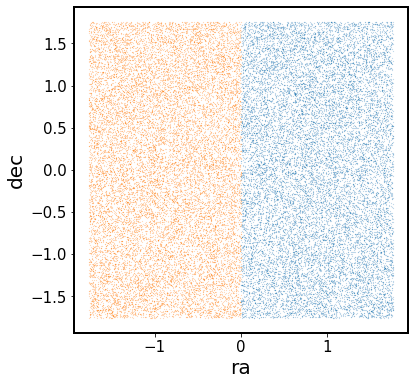

In [16]:
# illustrate the stars that we got : 
%matplotlib inline 

fig,ax =plt.subplots(1,1,figsize=(6,6))
ax.scatter(r1['ra'], r1['dec'], s = 0.01)
ax.scatter(r2['ra_'], r2['dec'],s=0.01)
ax.set_xlabel('ra')
ax.set_ylabel('dec')

In [18]:
# Convert from pandas to astropy, and merge both tables 
r1t = Table.from_pandas(r1)
r2t = Table.from_pandas(r2)


# during the merger we loose ra_ column ,
# which is fine, because PhoSim takes ra in 0,360 format 
results = vstack([r1t, r2t], join_type='inner')
results['starId'] = np.arange(len(results))

# Save as ascii file for future reference ... 
fname  = 'GaiaDR2_LSST_FOV_40k_stars.txt'
results.write(fname, format='ascii')

# Read the file 
#results = Table.read(fname, format='ascii')

In [19]:
# Store as PhoSim catalog ...

# Add the header (star ID, ra, decl, magnitude)

cutMag = 11  # this only removes the 
selection = results[results['phot_g_mean_mag'] > cutMag]
selection['starId'] = np.arange(len(selection))

# Add the star information
content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
for i in range(len(selection['starId'])):
    content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
        selection['starId'][i], selection['ra'][i], selection['dec'][i], selection['phot_g_mean_mag'][i])
path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
fname = 'starCatGAIA_gt'+str(cutMag)+'_wfs.txt'
outputFilePath = path+fname

# Write into file
fid = open(outputFilePath, "w")
fid.write(content)
fid.close()



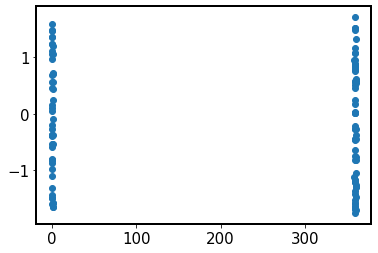

In [12]:
%matplotlib inline
#Read the stored GAIA DR2 data, and 
#save a much smaller catalog with only a few stars....
fname  = 'GaiaDR2_LSST_FOV_40k_stars.txt'
results = Table.read(fname, format='ascii')
m = (16 <  results['phot_g_mean_mag'] ) * ( results['phot_g_mean_mag'] <16.05)
plt.scatter(results['ra'][m], results['dec'][m])


Perhaps it's just  easier to make a simulation that puts one star on each WFS sensor to see if it works at all ... 

## Make GAIA catalogs at 4 different Galactic locations...

Show Galfast simulation as background : 

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 13
rcParams['xtick.labelsize'] = 13
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
from astropy.io import fits

In [4]:
def make_healpix_table(r_max=24.5):
    ''' A convenience function 
    to read in the MAF simulation data,
    and given the limiting r magnitude, 
    return stellar density per healpixel,
    and the fraction of healpixels with higher
    density , together with ra,dec coord 
    of each healpixel. We use the constraint 
    r < r_max, with  65 magnitude bins between 
    15 and 28 mag every 0.2 mag. 
    
    '''
    # the data consists of 
    # data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
    # data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
    # data['overMaxMask'], which tells where there are more than 1e6 stars 
    data = np.load('starDensity_r_nside_64.npz')


    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    mag_bins = data['bins'].copy()
    # pixels where there were so many  (1e6 ) stars some were skipped
    mask = data['overMaxMask'].copy()
    # in this simulation none were skipped : 
    # np.sum(mask) = 0

    # select only bins up to r_max - then selecting the final bin will 
    # give us the source count up to depth of r_max mag 
    bright_mag_idx, = np.where(mag_bins<r_max)
    print('Selecting only the source density up \
    to the depth of ', r_max, ' mag')
    faintest_mag_idx = bright_mag_idx[-1]

    # Since the data is already cumulative, just choose the  last bin: 
    # this will have the number of stars up to the faintest magnitude 
    # bin in a given  healpixel 
    starDensity_lt_245 = data['starDensity'][:,faintest_mag_idx]
    # len(starDensity_lt_245) = len(data['starDensity]) = 49142

    # Generate the ra, dec array from healpy
    nside = hp.npix2nside(np.size(mask))
    lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
    dec = np.pi/2-lat

    # only select those healpixels for which we have any simulation data ...
    m = starDensity_lt_245 > 0

    density = starDensity_lt_245[m]
    ra = ra[m]
    dec = dec[m]

    # For each pixel calculate how many pixels have a higher or equal density 
    N_px_greater  = np.zeros_like(density)
    for i in range(len(density)):
        N_px_greater[i]=np.sum(density>=density[i])

    # calculate the fraction of pixels that have a higher density (by area)
    frac_greater  = N_px_greater /  len(density)

    # Make an AstroPy table with healpix data...

    healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                          names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                                 'frac_greater'))
    return healpix_table , nside

In [5]:
healpix_table, nside = make_healpix_table()

Selecting only the source density up     to the depth of  24.5  mag


In [4]:
healpix_table[:10]

source_density,ra_rad,dec_rad,N_px_greater,frac_greater
float64,float64,float64,float64,float64
10476.0,0.0,0.6100600350363932,24429.0,0.6298731435643564
11916.0,0.02454369260617026,0.6100600350363932,22679.0,0.5847514438943895
11160.0,0.04908738521234052,0.6100600350363932,23582.0,0.6080342409240924
9756.0,0.07363107781851078,0.6100600350363932,25488.0,0.6571782178217822
10044.0,0.09817477042468103,0.6100600350363932,25058.0,0.6460911716171617
9756.0,0.12271846303085128,0.6100600350363932,25488.0,0.6571782178217822
10908.0,0.14726215563702155,0.6100600350363932,23901.0,0.6162592821782178
9684.0,0.1718058482431918,0.6100600350363932,25606.0,0.6602207095709571
9288.0,0.19634954084936207,0.6100600350363932,26169.0,0.674737004950495


In [7]:
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

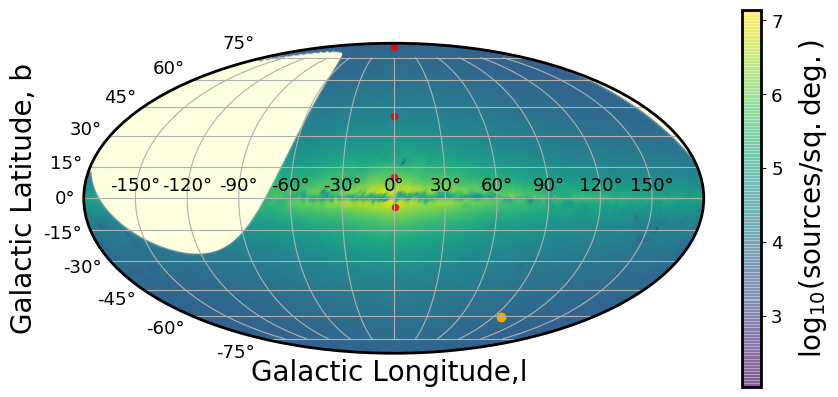

In [52]:
# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import matplotlib
#from astroML.plotting import setup_text_plots
rcParams = matplotlib.rcParams
#from astroML.plotting import setup_text_plots
#setup_text_plots( usetex=True)

def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
# plotting  in mollweide projection ...  
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
healpix_longitude = healpix_coords.galactic.l.deg
healpix_latitude  = healpix_coords.galactic.b.deg

# shift the scale : healpix is 0, 360, and we want to go -180,180 
ind = healpix_longitude > 180
healpix_longitude[ind] -=360    # scale conversion to [-180, 180]
healpix_longitude = - healpix_longitude   # reverse the scale: East to the left

# color by the log of counts per sq deg 
z =  np.log10(healpix_table['source_density'].data)

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(healpix_longitude),
                  np.radians(healpix_latitude),  
                  alpha=0.4, s=14, c=z,
                  zorder=-5) # make sure that the background is underneath everything else with zorder  

# plot the four GAIA fields 
gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_longitude = gaia_coords.galactic.l.rad
gaia_latitude = gaia_coords.galactic.b.rad

# this only plots the gaia coords as same-size markers. 
ax.scatter(gaia_longitude, gaia_latitude, alpha=0.8, s=20,c='red')

# We can do better - mark the actual size of comcam-like field at each location 
# (change a - half-width of comcam field in degrees - to eg. 10, to 
# see that the distortions that you'd expect when 
# displaying in galactic coords are present 
a = np.radians(0.352) # degrees 
for i in range(len(gaia_longitude)):
    xc = gaia_longitude[i]
    yc = gaia_latitude[i]

    rectangle = [xc-a, yc-a, 2*a,2*a]

    # add a red rectangle ..
    x0, y0, w, h = rectangle # lower-left corner, width, height
    rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                             edgecolor='r',facecolor='red', alpha=0.5)
    # Add the patch to the Axes
    ax.add_patch(rect)

# # Note: where is (0,0) which we simulated earlier ? 
coord = SkyCoord(ra=0, dec=0, frame='icrs', unit='deg')
ax.scatter(coord.galactic.l.rad,coord.galactic.b.rad,c='orange' )
# plot the DECAPS fields 
# long, lat = decaps_coords.galactic.l.deg , decaps_coords.galactic.b.deg
# ind = long > 180
# long[ind] -=360    # scale conversion to [-180, 180]
# long = - long   # reverse the scale: East to the left
# ax.scatter(np.radians(long), np.radians(lat), alpha=0.07,c='red',s =4)

# plot the confusion zone 
# xs = [0,-90,0,90,0]
# ys = [10,0,-10,0,10]
# for i in range(len(xs)-1):
#     x0,y0 = xs[i],ys[i]
#     x1,y1  = xs[i+1],ys[i+1]
#     ax.plot(np.radians([x0,x1]), 
#             np.radians([y0,y1]),
#             lw=3,ls='--',c='red')
    
# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)
#plt.savefig('MAF_DECAPS.png',  bbox_inches='tight')

Four locations to simulate: high (80-90 deg); mid (30-50 deg); low (0 - 20 deg)
    
    


In [56]:
gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

Plot the same in equatorial coordinates : 

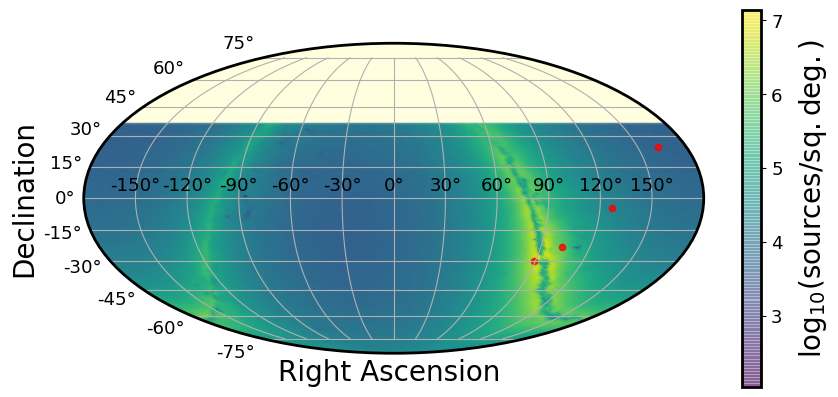

In [34]:
# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import matplotlib
#from astroML.plotting import setup_text_plots
rcParams = matplotlib.rcParams


def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
# plotting  in mollweide projection ...  
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
#healpix_longitude = healpix_coords.galactic.l.deg
#healpix_latitude  = healpix_coords.galactic.b.deg

healpix_ra = healpix_coords.icrs.ra.deg
healpix_dec = healpix_coords.icrs.dec.deg
    
    
# shift the scale : healpix is 0, 360, and we want to go -180,180 
ind = healpix_ra > 180
healpix_ra[ind] -=360    # scale conversion to [-180, 180]
healpix_ra = - healpix_ra   # reverse the scale: East to the left

# color by the log of counts per sq deg 
z =  np.log10(healpix_table['source_density'].data)

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(healpix_ra),
                  np.radians(healpix_dec),  
                  alpha=0.4, s=14, c=z,
                  zorder=-5) # make sure that the background is underneath everything else with zorder  
# plot the four GAIA fields 
gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

ind = gaia_ra > 180
gaia_ra[ind] -=360    # scale conversion to [-180, 180]
gaia_ra = - gaia_ra

# this only plots the gaia coords as same-size markers. 
ax.scatter(np.radians(gaia_ra), np.radians(gaia_dec), alpha=0.8, s=20,c='red')


# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Right Ascension ')
ax.set_ylabel('Declination')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)

plt.savefig('dr2_location_equatorial.png',  bbox_inches='tight', dpi=100)

In [ ]:

# plot the four GAIA fields 
gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_ra = gaia_coords.icrs.ra.rad
gaia_dec = gaia_coords.icrs.dec.rad

# this only plots the gaia coords as same-size markers. 
ax.scatter(gaia_longitude, gaia_latitude, alpha=0.8, s=20,c='red')

# We can do better - mark the actual size of comcam-like field at each location 
# (change a - half-width of comcam field in degrees - to eg. 10, to 
# see that the distortions that you'd expect when 
# displaying in galactic coords are present 
a = np.radians(0.352) # degrees 
for i in range(len(gaia_longitude)):
    xc = gaia_longitude[i]
    yc = gaia_latitude[i]

    rectangle = [xc-a, yc-a, 2*a,2*a]

    # add a red rectangle ..
    x0, y0, w, h = rectangle # lower-left corner, width, height
    rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                             edgecolor='r',facecolor='red', alpha=0.5)
    # Add the patch to the Axes
    ax.add_patch(rect)

# # Note: where is (0,0) which we simulated earlier ? 
#coord = SkyCoord(ra=0, dec=0, frame='icrs', unit='deg')
#ax.scatter(coord.galactic.l.rad,coord.galactic.b.rad,c='orange' )
# plot the DECAPS fields 
# long, lat = decaps_coords.galactic.l.deg , decaps_coords.galactic.b.deg
# ind = long > 180
# long[ind] -=360    # scale conversion to [-180, 180]
# long = - long   # reverse the scale: East to the left
# ax.scatter(np.radians(long), np.radians(lat), alpha=0.07,c='red',s =4)

# plot the confusion zone 
# xs = [0,-90,0,90,0]
# ys = [10,0,-10,0,10]
# for i in range(len(xs)-1):
#     x0,y0 = xs[i],ys[i]
#     x1,y1  = xs[i+1],ys[i+1]
#     ax.plot(np.radians([x0,x1]), 
#             np.radians([y0,y1]),
#             lw=3,ls='--',c='red')
    
# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Right Ascension ')
ax.set_ylabel('Declination')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)
#plt.savefig('MAF_DECAPS.png',  bbox_inches='tight')

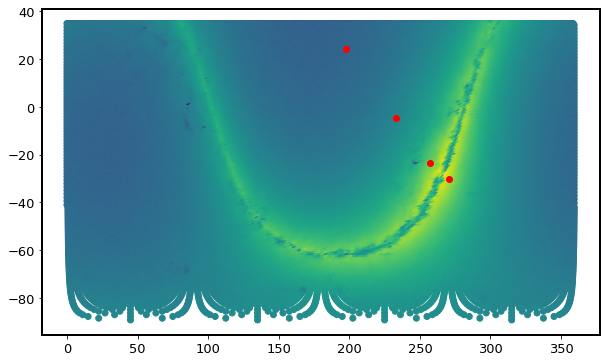

In [47]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(healpix_coords.ra.deg, healpix_coords.dec.deg,c=z)
ax.scatter(gaia_coords.icrs.ra.deg, gaia_coords.icrs.dec.deg, c='red')

Note:  GAIA DR2 catalog is in ra(0,360)  dec(-90,90) format 

## Make a new catalog at requisite locations 

In [1]:
#NB: use Python 3 - AXS Spark kernel for that 
#that's the one that has mariadb...

import pandas as pd
import numpy as np
import mysql.connector as mariadb
from astropy.time import Time
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns',100)
pd.set_option('float_format', '{:f}'.format)

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

import pyspark.sql.functions as sparkfunc
from pyspark.sql import SparkSession

spark_session = (SparkSession.builder
         .config('spark.master', "local[20]")
         .config('spark.driver.memory', '20G')
         .enableHiveSupport()
         .getOrCreate())

import axs
axs_catalog = axs.AxsCatalog(spark_session)

In [4]:
#axs_catalog.list_table_names()
#axs_catalog.table_info('gaia_dr2_1am_dup')
gaia = axs_catalog.load("gaia_dr2_1am_dup")
#np.ravel(gaia.columns)

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [ ]:
# Define locations for query : convert from 
# galactic to equatorial 
gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

In [ ]:
gaia_ra

Make a spark query : 

In [6]:
%%time 

a = 0.387 # half-width of comcam FOV in deg  - needed to increase from .352,
# because while this was enough in ra, it left a stripe about 10% of the CCD size
# iterate over centers of each square 

# note:  _gaia_DR2_comcam.txt   used a = 0.352, but it turned out insufficient on the edges,
# so I expanded that to a = 0.387, storing as _gaia_DR2_comcam_wide.txt
for ra, dec, name in zip(gaia_ra, gaia_dec,gt['name'] ):
    ra_min = ra - a
    ra_max = ra + a
    dec_min = dec - a 
    dec_max = dec + a 
    print('Querying  %s:  %.3f<ra<%.3f   , %.3f<dec<%.3f'%\
          (name, ra_min,ra_max,dec_min,dec_max))
    res_pd = gaia.region(ra1=ra_min, ra2=ra_max, 
                         dec1=dec_min, dec2=dec_max).select("ra", 
                        "dec","phot_g_mean_mag","phot_variable_flag",
                        "designation",  "phot_g_n_obs","dup").toPandas()
    res = Table.from_pandas(res_pd)
    res.write(name+'_gaia_DR2_comcam_wide.txt',format='ascii')

Querying  high:  197.077<ra<197.851   , 23.949<dec<24.723
Querying  med:  232.630<ra<233.404   , -4.834<dec<-4.060
Querying  low:  256.723<ra<257.497   , -23.797<dec<-23.023
Querying  Baade:  270.497<ra<271.271   , -30.422<dec<-29.648
CPU times: user 27.5 s, sys: 2.16 s, total: 29.7 s
Wall time: 1min 48s


Four galactic fields are : 

high (l,b) = (0,85) ;  1362 stars  (1355  if g<11) 
med (l,b) = (0,40) ; 4489 stars  (4476   if g<11) 
low (l,b) = (0,10) ; 172851 stars  (172827 if g<11) 
Baade (l,b) = (1.02, -3.92) ; 423385 stars (423343  if g<11) 


In [38]:
#Count the stars 
stars = {}
for i in range(len(gt)):
    name = gt['name'][i]
    t = Table.read(name+'_gaia_DR2_comcam.txt',format='ascii')
    stars[name] = t 
    print('For %s we have %d stars'%(name,len(t)))

For high we have 1362 stars
For med we have 4489 stars
For low we have 172851 stars
For Baade we have 423385 stars


Show what they look like : 
    


0.0 0.7020556786888505
0.0 0.70318618229593
0.0 0.7035052513586209
0.0 0.7037949941703658
0.0 0.7039924063918761
0.0 0.7039891745337634
0.0 0.7039987309981939
0.0 0.7039979470582232


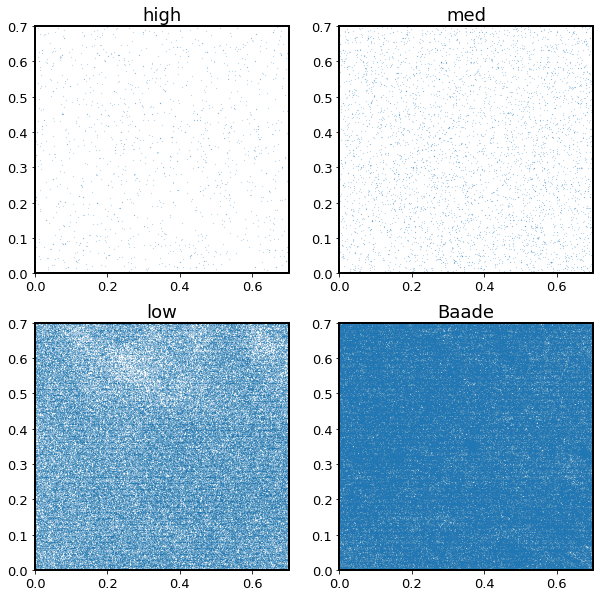

In [52]:
%matplotlib inline
fig,axs  = plt.subplots(2,2,figsize=(10,10))
ax = np.ravel(axs)
i = 0 
for name in stars.keys():
    ra = stars[name]['ra'] - min(stars[name]['ra'])
    dec =  stars[name]['dec'] - min( stars[name]['dec'])
    print(min(ra), max(ra))
    print(min(dec), max(dec))
    ax[i].scatter(ra,dec,s=0.01)#, bins='log')
    ax[i].set_title(name)
    ax[i].set_xlim(0,0.7)
    ax[i].set_ylim(0,0.7)
    i += 1 

In Baade's window we see NGC6522 (left) and NGC6528 (right)  : 

Text(0, 0.5, 'dec')

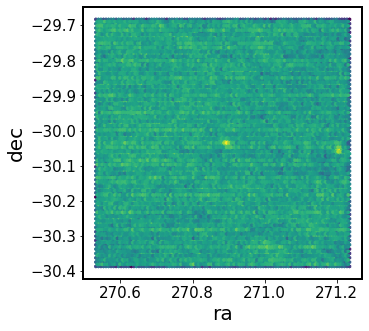

In [114]:
name='Baade'
fig,ax=  plt.subplots(1,1,figsize=(5,5))
ax.hexbin(stars[name]['ra'], stars[name]['dec'], bins='log')

ngc6528  = SkyCoord(ra='18h 04m 49.61s',dec='−30° 03′ 20.8″', 
                    frame='icrs')
ngc6522 = SkyCoord(ra='18h 3m 34.1s', dec='−30° 2′ 2.3″',
                  frame='icrs')
ax.set_xlabel('ra')
ax.set_ylabel('dec')
#ax.scatter(ngc6528.icrs.ra.deg, ngc6528.icrs.dec.deg, marker='D', s=100) # right 

Save these catalogs with and without g>11 cut   as PhoSim catalogs ... (Note that the output of AXS is (0,360) , (-90,90), which is the same format as that of PhoSim). 

First, with cut magnitude : 

In [9]:
import os

cutMag = 11 
aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)
for name in stars.keys():
    mask = stars[name]['phot_g_mean_mag'] > cutMag 
    selection = stars[name][mask]
    selection['starId'] = np.arange(len(selection))
    print('Saving PhoSim star catalog for %s , g>%d : %d stars '%(name, cutMag, len(selection)))
    
    # Add the header (star ID, ra, decl, magnitude)
    content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
    for i in range(len(selection['starId'])):
        content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
            selection['starId'][i], selection['ra'][i], selection['dec'][i], 
            selection['phot_g_mean_mag'][i])
    path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
    fname = 'starCatGAIA_'+name+'_gt'+str(cutMag)+'.txt'
    outputFilePath = path+fname

    # Write into file
    fid = open(outputFilePath, "w")
    fid.write(content)
    fid.close()

Saving PhoSim star catalog for high , g>11 : 1355 stars 
Saving PhoSim star catalog for med , g>11 : 4476 stars 
Saving PhoSim star catalog for low , g>11 : 172827 stars 
Saving PhoSim star catalog for Baade , g>11 : 423343 stars 


Also, save full catalogs with all stars: 

In [10]:
import os


aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)
for name in stars.keys():
    selection = stars[name]
    selection['starId'] = np.arange(len(selection))
    print('Saving PhoSim star catalog for %s : %d stars '%(name, len(selection)))
    
    # Add the header (star ID, ra, decl, magnitude)
    content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
    for i in range(len(selection['starId'])):
        content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
            selection['starId'][i], selection['ra'][i], selection['dec'][i], 
            selection['phot_g_mean_mag'][i])
    path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
    fname = 'starCatGAIA_'+name+'_full.txt'
    outputFilePath = path+fname

    # Write into file
    fid = open(outputFilePath, "w")
    fid.write(content)
    fid.close()

Saving PhoSim star catalog for high : 1362 stars 
Saving PhoSim star catalog for med : 4489 stars 
Saving PhoSim star catalog for low : 172851 stars 
Saving PhoSim star catalog for Baade : 423385 stars 


Address the issue with low and Baade fields, that somehow PhoSim seems to cut out the catalog  - take low, and feed with subsampled catalog, check if that makes a difference ...

From Baade_gaia_DR2_comcam.txt
We subsample 8000 objects of the initial 423385
Saving PhoSim star catalog for Baade , g>11 : 7999 stars 
Saved as starCatGAIA_Baade_gt11_narrow_sub.txt


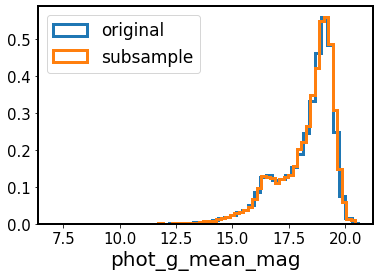

In [44]:
import os

stars={}
name = 'Baade'
fin = name+'_gaia_DR2_comcam.txt'
print('From %s'%fin)
t = Table.read(fin,format='ascii')

stars[name] = t 

# choose random indices
indices = np.arange(len(stars[name]))
N = 8000
rand_indices = np.random.choice(indices,size=N, replace=False)
print('We subsample %d objects of the initial %d'%(N, len(indices)))
sample = stars[name][rand_indices]

# show that their distribution is the same ...
%matplotlib inline
plt.hist(stars[name]['phot_g_mean_mag'], density=True, histtype='step', bins=50,
        label='original', lw=3)
plt.hist(sample['phot_g_mean_mag'],density=True, histtype='step', bins=50, 
         label='subsample',lw=3)
plt.xlabel('phot_g_mean_mag')
plt.legend(loc='upper left', fontsize=17)


# save the subsample as PhoSim catalog 
cutMag = 11 
aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)

mask = sample['phot_g_mean_mag'] > cutMag 
selection = sample[mask]
selection['starId'] = np.arange(len(selection))
print('Saving PhoSim star catalog for %s , g>%d : %d stars '%(name, cutMag, len(selection)))

# Add the header (star ID, ra, decl, magnitude)
content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
for i in range(len(selection['starId'])):
    content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
        selection['starId'][i], selection['ra'][i], selection['dec'][i], 
        selection['phot_g_mean_mag'][i])
path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
fname = 'starCatGAIA_'+name+'_gt'+str(cutMag)+'_narrow_sub.txt'
outputFilePath = path+fname
print('Saved as %s'%fname)
# Write into file
fid = open(outputFilePath, "w")
fid.write(content)
fid.close()



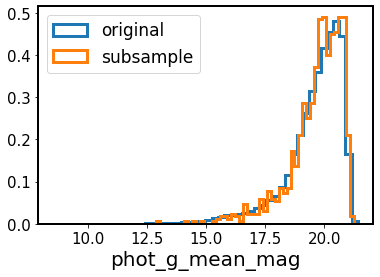

Saving PhoSim star catalog for low , g>11 : 1000 stars 
Saved as starCatGAIA_low_gt11_sub.txt


Pointing at different locations on the sky - apart from raInDeg,  decInDeg, which settings need to be changed to  correctly point to a new location ? 

My question : "If I have fields that I want to simulate at different (ra,deg),  is it sufficient to feed PhoSim with different `raInDeg` , `decInDeg` values to override `surveySettings,yaml`, or do I also need to change  `rotAngInDeg` (from default 0 deg), or the `zAngleInDeg` (from default 27.0912) ?"

Te-Wei's Answer (June 23rd): "At this moment, you could just use `raInDeg` and `decInDeg` . I tested them before already. For the `zAngleInDeg`, it will just do minor distortion simulation of camera and should not affect the main conclusion. For the `rotAngInDeg`, the PhoSim does not do the optical correction well. It just affects the star's position, which will rotate the star only. However, the OPD is not rotated. You can see my previous study here:
https://confluence.lsstcorp.org/display/LTS/Closed-Loop+Simulation+with+Non-Zero+Camera+Rotation+Angle 
Therefore, if you want to rotate the camera rotation angle with the correct OPD, maybe the hack of PhoSim is needed."

So in the end, to point at different locations at this point I calculated OPD, calibs  for high latitude (ra,dec for high),  rot=0, zAngle=27.09, 
and then only re-calculated defocal and in-focus images changing (ra,dec) for each field 

In [135]:
import datetime
import time

now = datetime.datetime.now()

# Wait for 5 seconds
time.sleep(1)

then = datetime.datetime.now()

delta = then-now


It took 0.017 minutes, i.e. 0.00028 hours 


In [132]:
def print_duration(delta):
    ''' Convenience function to print execution time 
    between time1 and time2. 
    
    Parameters:
    ----------
    delta : datetime.timedelta() object,
    result of eg. 
    time1 = datetime.datetime.now()
    time2 = datetime.datetime.now()
    delta = time2 - time1 
    
    Returns:
    --------
    None

    '''
    delta_sec = delta.total_seconds()
    delta_min = delta_sec / 60
    delta_hr = delta_min / 60
    print('It took %.3f minutes, i.e. %.5f hours ' % (delta_min, delta_hr))

0.016697833333333335

# Make GAIA DR2 catalog at various locations for the WFS corner sensors ... 


Each time query GAIA DR2 at locations corresponding to four corner WFS sensors. 

FOR GAIA DR2 queries need `Python 3 - AXS Spark` kernel, whereas for work with `ts_phosim` need `lsst_phosim` kernel... So make a separate notebook to create (ra,dec) of the centers of the four wavefront sensors if the boresight is (0,0), so that I get an offset from the center of the field (for comcam) to the wavefront sensors in (ra,dec). 



Read the list of centers of four corner WFS sensors (assuming the boresight is (0,0):)

In [2]:
from astropy.table import Table
wfs = Table.read('GAIA_WFS_center_coords.txt', format='ascii')

In [3]:
wfs

ra,dec,xPx,yPx,sensorName,imType
float64,float64,float64,float64,str10,str6
1.1811817965673403,1.1785818078976729,2000.0,2036.0,R44_S00_C0,center
-1.1798258700895872,-1.178145473993399,2000.0,2036.0,R00_S22_C0,center
1.1767622392809642,-1.1746966484405015,2000.0,2036.0,R40_S02_C0,center
-1.176989741614534,1.174289071077627,2000.0,2036.0,R04_S20_C0,center


In [5]:
from astropy.coordinates import SkyCoord
# locations of each field already queried - 
# these are the centers of each field, 
# i.e. the boresight of the telescope 

# The three galactic fields are defined in galactic coords -
# convert them to equatorial 
gt = Table(data=[['high','med','low','Baade'],
                 [0,0,0,1.02],
                 [85,40,10,-3.92 ]], 
                 names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

gt['ra_cen'] = gaia_ra
gt['decl_cen'] = gaia_dec

In [52]:
gt

name,l_deg,b_deg,ra_cen,decl_cen
str5,float64,float64,float64,float64
high,0.0,85.0,197.46441300863182,24.33554243027582
med,0.0,40.0,233.01733592061052,-4.447088188407342
low,0.0,10.0,257.11044958320826,-23.40973217864059
Baade,1.02,-3.92,270.88380338652223,-30.035274475954893


Given these, and the offsets from the center  to the WFS, I find the coords for WFS:

In [6]:

fieldName = []
sensorName = []
raInDeg = []
declInDeg = []

for i in range(len(gt)):
    field = gt['name'][i]
    print('\n%s'%field)
    raCen, declCen = gt['ra_cen'][i], gt['decl_cen'][i]
    
    print(raCen, declCen)
    
    for j in range(len(wfs)):
        dra = wfs['ra'][j]
        ddec = wfs['dec'][j]
        raWfs = raCen + dra
        decWfs = declCen + ddec
        sensor = wfs['sensorName'][j]
        
        print(sensor, raWfs, decWfs)
        
        fieldName.append(field)
        sensorName.append(sensor)
        raInDeg.append(raWfs)
        declInDeg.append(decWfs)
        
wfsGaiaCoords = Table(data=[fieldName, sensorName, raInDeg, declInDeg], 
                      names=['fieldName', 'sensorName', 'raInDeg', 'declInDeg'])


high
197.46441300863182 24.33554243027582
R44_S00_C0 198.64559480519915 25.51412423817349
R00_S22_C0 196.28458713854224 23.15739695628242
R40_S02_C0 198.6411752479128 23.160845781835317
R04_S20_C0 196.2874232670173 25.509831501353446

med
233.01733592061052 -4.447088188407342
R44_S00_C0 234.19851771717785 -3.2685063805096695
R00_S22_C0 231.83751005052093 -5.625233662400741
R40_S02_C0 234.1940981598915 -5.621784836847843
R04_S20_C0 231.840346178996 -3.272799117329715

low
257.11044958320826 -23.40973217864059
R44_S00_C0 258.2916313797756 -22.231150370742917
R00_S22_C0 255.93062371311868 -24.58787765263399
R40_S02_C0 258.2872118224892 -24.58442882708109
R04_S20_C0 255.93345984159373 -22.23544310756296

Baade
270.88380338652223 -30.035274475954893
R44_S00_C0 272.06498518308956 -28.85669266805722
R00_S22_C0 269.70397751643264 -31.213419949948292
R40_S02_C0 272.0605656258032 -31.209971124395395
R04_S20_C0 269.7068136449077 -28.860985404877265


In [55]:
wfsGaiaCoords

fieldName,sensorName,raInDeg,declInDeg
str5,str10,float64,float64
high,R44_S00_C0,198.64559480519915,25.51412423817349
high,R00_S22_C0,196.28458713854224,23.15739695628242
high,R40_S02_C0,198.6411752479128,23.160845781835317
high,R04_S20_C0,196.2874232670173,25.509831501353446
med,R44_S00_C0,234.19851771717785,-3.2685063805096695
med,R00_S22_C0,231.83751005052093,-5.625233662400741
med,R40_S02_C0,234.1940981598915,-5.621784836847843
med,R04_S20_C0,231.840346178996,-3.272799117329715
low,R44_S00_C0,258.2916313797756,-22.231150370742917


In [8]:
#NB: use Python 3 - AXS Spark kernel for that 
#that's the one that has mariadb...

import pandas as pd
import mysql.connector as mariadb

import pyspark.sql.functions as sparkfunc
from pyspark.sql import SparkSession

spark_session = (SparkSession.builder
         .config('spark.master', "local[20]")
         .config('spark.driver.memory', '20G')
         .enableHiveSupport()
         .getOrCreate())

import axs
axs_catalog = axs.AxsCatalog(spark_session)
gaia = axs_catalog.load("gaia_dr2_1am_dup")

In [9]:
%%time 

a = 0.387# half-width of comcam FOV in deg  - needed to increase from .352,
# because while this was enough in ra, it left a stripe about 10% of the CCD size
# iterate over centers of each square 

#a = a/3.0 # since for WFS each field is basically one ComCam sensor, and ComCam FOV 
# is 3x3 sensors 

# note:  _gaia_DR2_comcam.txt   used a = 0.352, but it turned out insufficient on the edges,
# so I expanded that to a = 0.387, storing as _gaia_DR2_comcam_wide.txt

for i in range(len(wfsGaiaCoords)):
    field = wfsGaiaCoords['fieldName'][i]
    sensor = wfsGaiaCoords['sensorName'][i]
    print(field,sensor)
    ra,dec = wfsGaiaCoords['raInDeg'][i], wfsGaiaCoords['declInDeg'][i]
    ra_min = ra - a ; ra_max = ra + a
    dec_min = dec - a ; dec_max = dec + a 
    print('Querying  %.3f<ra<%.3f   , %.3f<dec<%.3f'%\
          (ra_min,ra_max,dec_min,dec_max))
    res_pd = gaia.region(ra1=ra_min, ra2=ra_max, 
                         dec1=dec_min, dec2=dec_max).select("ra", 
                        "dec","phot_g_mean_mag","phot_variable_flag",
                        "designation",  "phot_g_n_obs","dup").toPandas()
    res = Table.from_pandas(res_pd)
    name = '%s_%s_gaia_DR2_0.387-deg_wide.txt'%(field,sensor)
    print('Saved as %s'%name)
    res.write(name,format='ascii')
    
print('Done')

high R44_S00_C0
Querying  198.259<ra<199.033   , 25.127<dec<25.901
Saved as high_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt
high R00_S22_C0
Querying  195.898<ra<196.672   , 22.770<dec<23.544
Saved as high_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
high R40_S02_C0
Querying  198.254<ra<199.028   , 22.774<dec<23.548
Saved as high_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
high R04_S20_C0
Querying  195.900<ra<196.674   , 25.123<dec<25.897
Saved as high_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
med R44_S00_C0
Querying  233.812<ra<234.586   , -3.656<dec<-2.882
Saved as med_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt
med R00_S22_C0
Querying  231.451<ra<232.225   , -6.012<dec<-5.238
Saved as med_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
med R40_S02_C0
Querying  233.807<ra<234.581   , -6.009<dec<-5.235
Saved as med_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
med R04_S20_C0
Querying  231.453<ra<232.227   , -3.660<dec<-2.886
Saved as med_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
low R44_S00_C0
Querying  257.905<ra<258.679   , 

In [11]:

import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
wfs = Table.read('GAIA_WFS_center_coords.txt', format='ascii')

In [5]:
np.unique(wfs['sensorName'].data)


array(['R00_S22_C0', 'R04_S20_C0', 'R40_S02_C0', 'R44_S00_C0'],
      dtype='<U10')

In [12]:
catalogs = {}
for field in ['high','med','low','Baade']:
    catalogs[field]  = {}
    for sensor in np.unique(wfs['sensorName'].data):
        name = '%s_%s_gaia_DR2_0.387-deg_wide.txt'%(field,sensor)
        catalogs[field][sensor] = Table.read(name, format='ascii')
        print('Read in %s'%name)

Read in high_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
Read in high_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
Read in high_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
Read in high_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt
Read in med_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
Read in med_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
Read in med_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
Read in med_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt
Read in low_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
Read in low_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
Read in low_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
Read in low_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt
Read in Baade_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt
Read in Baade_R04_S20_C0_gaia_DR2_0.387-deg_wide.txt
Read in Baade_R40_S02_C0_gaia_DR2_0.387-deg_wide.txt
Read in Baade_R44_S00_C0_gaia_DR2_0.387-deg_wide.txt


In [13]:
from astropy.table import  vstack

combined  = {}
for field in ['high','med','low','Baade']:
    combined[field] = vstack([catalogs[field]['R00_S22_C0'], 
                          catalogs[field]['R04_S20_C0'],
                          catalogs[field]['R40_S02_C0'],
                          catalogs[field]['R44_S00_C0']
                         ])


In [14]:
catalogType = 'full'
halfWidth = 0.387 
for field in ['high','med','low','Baade']:
    fname = 'starCatGAIA_%s_%s_WFS_%.3f.txt'%(field,catalogType,halfWidth)
    print(fname)
    combined[field].write(fname,format='ascii' )

starCatGAIA_high_full_WFS_0.387.txt
starCatGAIA_med_full_WFS_0.387.txt
starCatGAIA_low_full_WFS_0.387.txt
starCatGAIA_Baade_full_WFS_0.387.txt


Store as PhoSim catalogs:

In [15]:
import os


aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)

catalogType = 'full'

for field in ['high','med','low','Baade']:
    selection = combined[field]
    selection['starId'] = np.arange(len(selection))
    print('\nSaving PhoSim WFS full GAIA DR2 star catalog for %s : %d stars '%(field, len(selection)))
    
    # Add the header (star ID, ra, decl, magnitude)
    content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
    for i in range(len(selection['starId'])):
        content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
            selection['starId'][i], selection['ra'][i], selection['dec'][i], 
            selection['phot_g_mean_mag'][i])
    path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
    fname = 'starCatGAIA_'+name+'_full.txt'
    fname = 'starCatGAIA_%s_%s_WFS_%.3f.txt'%(field,catalogType,halfWidth)
    print('Saving as %s'%fname)
    outputFilePath = path+fname

    # Write into file
    fid = open(outputFilePath, "w")
    fid.write(content)
    fid.close()

Saving PhoSim WFS full GAIA DR2 star catalog for high : 6526 stars 
Saving as starCatGAIA_high_full_WFS_0.387.txt
Saving PhoSim WFS full GAIA DR2 star catalog for med : 21919 stars 
Saving as starCatGAIA_med_full_WFS_0.387.txt
Saving PhoSim WFS full GAIA DR2 star catalog for low : 690111 stars 
Saving as starCatGAIA_low_full_WFS_0.387.txt
Saving PhoSim WFS full GAIA DR2 star catalog for Baade : 1965231 stars 
Saving as starCatGAIA_Baade_full_WFS_0.387.txt


Store also the truncated version:

In [16]:
import os

aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)

catalogType = 'gt11'
cutMag = 11

for field in ['high','med','low','Baade']:
    
    selection = combined[field]
    mask = selection['phot_g_mean_mag'] > cutMag
    selection = selection[mask]
    selection['starId'] = np.arange(len(selection))
    print('\nSaving PhoSim WFS gt11 GAIA DR2 star catalog for %s : %d stars '%(field, len(selection)))
    
    # Add the header (star ID, ra, decl, magnitude)
    content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
    for i in range(len(selection['starId'])):
        content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
            selection['starId'][i], selection['ra'][i], selection['dec'][i], 
            selection['phot_g_mean_mag'][i])
    path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
    fname = 'starCatGAIA_%s_%s_WFS_%.3f.txt'%(field,catalogType,halfWidth)
    outputFilePath = path+fname
    print('   as %s'%fname)
    # Write into file
    fid = open(outputFilePath, "w")
    fid.write(content)
    fid.close()


Saving PhoSim WFS gt11 GAIA DR2 star catalog for high : 6493 stars 
   as starCatGAIA_high_gt11_WFS_0.387.txt

Saving PhoSim WFS gt11 GAIA DR2 star catalog for med : 21870 stars 
   as starCatGAIA_med_gt11_WFS_0.387.txt

Saving PhoSim WFS gt11 GAIA DR2 star catalog for low : 690019 stars 
   as starCatGAIA_low_gt11_WFS_0.387.txt

Saving PhoSim WFS gt11 GAIA DR2 star catalog for Baade : 1964941 stars 
   as starCatGAIA_Baade_gt11_WFS_0.387.txt


In [29]:
os.listdir(path)

['noMagCut',
 '.DS_Store',
 '._.DS_Store',
 'starCatGAIA.txt',
 '._starCatGAIA_gt11.txt',
 'starCatGAIA_gt11.txt',
 'gMagGt11',
 'gMagGt11_R22',
 'gMagGt11_R22_',
 'starCatGAIA_gt11_wfs.txt',
 'gMagGt11_WFS_',
 'gMagGt11_',
 'gMagGt11_w_2020_15',
 'gMagGt11_w_2020_15_test',
 'gMagGt11_w_2020_15_convolveTemplate',
 'screenlog.gMagGt11_w_2020_15_convolveTemplate.txt',
 'screenlog.gMagGt11_w_2020_15_noDeblending.txt',
 'starCatGAIA_high_gt11.txt',
 'starCatGAIA_med_gt11.txt',
 'starCatGAIA_low_gt11.txt',
 'starCatGAIA_Baade_gt11.txt',
 'starCatGAIA_high_full.txt',
 'starCatGAIA_med_full.txt',
 'starCatGAIA_low_full.txt',
 'starCatGAIA_Baade_full.txt',
 'test.txt',
 '._test.txt',
 'focalTest',
 '._screenlog.0',
 '._starCatGAIA_high_gt11.txt',
 'dr2_high_gt11',
 'dr2_med_gt11',
 '._starCatGAIA_med_gt11.txt',
 'dr2_low_gt11',
 'dr2_Baade_gt11',
 'dr2_high_full',
 'dr2_low_g11_old',
 'screenlog.0',
 'dr2_med_full',
 'dr2_high_gt11_reingest',
 'dr2_med_gt11_reingest',
 'dr2_low_g11_old ',
 'st

problems with phosim repackager...